In [56]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [57]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [58]:
len(words)

32033

In [59]:
# build the vocab of chars and mapping to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [60]:
# build the dataset
block_size = 3 # context length: how many chars we take to predict the next?
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [61]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [62]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many chars we take to predict the next?
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [63]:
C = torch.randn((27,2))

In [64]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [65]:
#torch.cat(torch.unbind(emb, 1), 1).shape # this is inefficient vs .view() because it creates a new tensor after concatinating taking up memory
#emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1) this comparison returns true showing view functions the same as cat and unbind while reducing memory use. view is just more efficient

In [66]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [67]:
# instead of emb.shape[0] you can put -1 and pytorch will infer the shape
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [68]:
h

tensor([[ 0.4688, -0.2432, -0.6061,  ...,  0.0610, -0.0031, -0.9261],
        [ 0.6052,  0.8473, -0.9435,  ..., -0.5062, -0.6640, -0.9893],
        [ 0.9893,  0.9087, -0.9103,  ..., -0.9803, -0.6867, -1.0000],
        ...,
        [ 0.9874, -0.4018, -0.4250,  ..., -0.4862,  0.5479, -0.9870],
        [ 0.9082,  0.1478, -0.5949,  ...,  0.9536,  0.0040,  0.3050],
        [-0.2517, -0.3765,  0.9926,  ..., -0.2878,  0.9601, -0.9899]])

In [69]:
h.shape

torch.Size([228146, 100])

In [70]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [71]:
logits = h @ W2 + b2

In [72]:
logits.shape

torch.Size([228146, 27])

In [73]:
counts = logits.exp()

In [74]:
prob = counts / counts.sum(1, keepdim=True)

In [75]:
prob.shape

torch.Size([228146, 27])

In [76]:
#loss = -prob[torch.arange(32), Y].log().mean()
#loss

In [77]:
# reorganize everything above-------------------------------------------------------------------------------------------------

In [78]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [79]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [80]:
sum(p.nelement() for p in parameters) # num params in total

11897

In [81]:
for p in parameters:
    p.requires_grad = True

In [82]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [83]:
lri = []
lossi = []
stepi = []

In [84]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    #counts = logits.exp()                                  | these 3 lines are equivalent to F.cross_entropy(logits, Y)
    #prob = counts / counts.sum(1, keepdim=True)            | in F.cross_entropy, pytorch doesn't make all the tensors 
    #loss = -prob[torch.arange(32), Y].log().mean()         | like in the 3 lines here so it is more efficient as extra memory isnt being taken up
    loss = F.cross_entropy(logits, Ytr[ix]) # reasons to do cross_entropy over the 3 lines, forward/backward pass is more efficient, and numerically more well behaved
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
#print(loss.item())

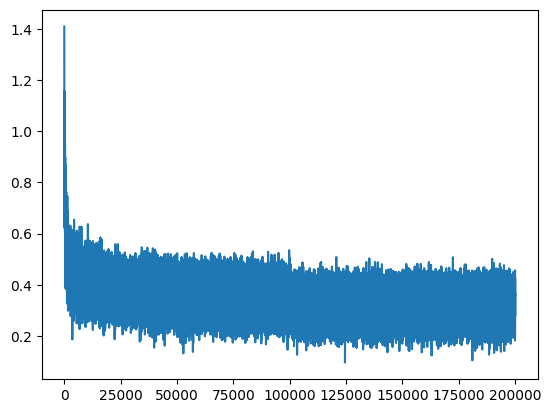

In [85]:
plt.plot(stepi, lossi)

In [86]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1145, grad_fn=<NllLossBackward0>)

In [87]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1601, grad_fn=<NllLossBackward0>)

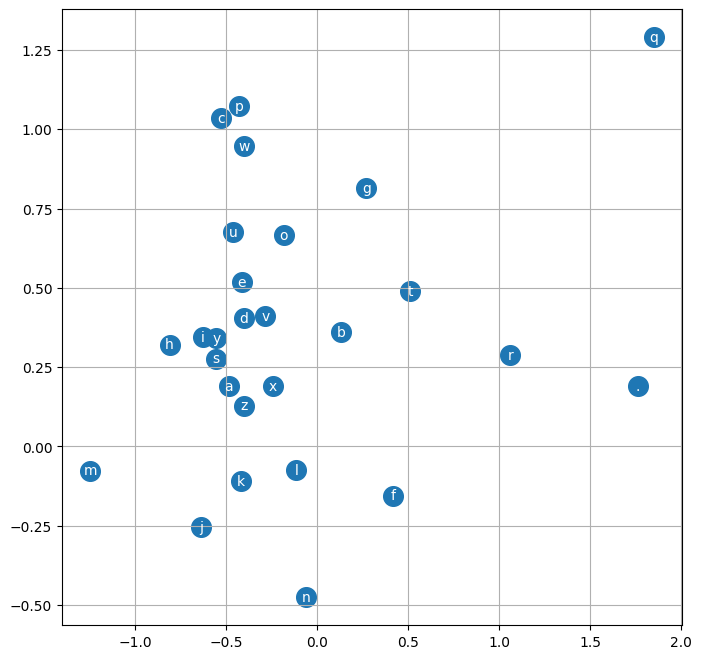

In [88]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [89]:
# training split, dev/validation split, test split
#80%, 10%, 10%

In [90]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # init with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amilli.
khirmin.
rey.
caspley.
kena.
huth.
den.
arci.
aqui.
nellara.
chaiiv.
kaleigh.
ham.
pory.
quintis.
lilea.
jadia.
wavero.
dearynix.
